In [1]:
from visual_genome.local import VisualGenome

```IMAGES``` dictionary: 
```json
id: {
  image: Image
  regions: [Region]
  objects: [Object]
}
```

```OBJECTS``` dictionary:  
```json
id: {
  object: Object
  attributes: [Attribute] 
  relationships: [Relationship]
}
```

```REGIONS``` dictionary:  ```id: Region``` \
```RELATIONSHIPS``` dictionary:  ```id: Relationship```

Some conflicts/observations:

* `attributes.json` includes the both merged objects, and objects that do no appear either as merged on in `objects.json` file. For example, for the first image, `objects.json` returns 31 objects, whereas `attributes.json` returns 40 objects. I'm ignoring the additional objects as `objects.json` is the most recent file.
* `attributes.json` contains objects, their synsets and attributes if any. There are conflicts between the bounding boxes, I'm sticking with the bounding boxes from `objects.json`.
* `attributes.json` contains multiple names for some of the objects, I'm sticking with the single names provided in `objects.json`.
* Each object has a single name. An object might have multiple (2 or 3) synsets or no synset at all. Usually they have 1 synset.
* Each relationship has either a single synset or no synset.


In [2]:
vg = VisualGenome() # may take couple of minutes to load the data

Loading data...
Data loaded.


In [3]:
rels_without_synsets = vg.get_entity_without_synsets("relationships")
print(len(rels_without_synsets))

15609


In [4]:
vg.OBJECTS[1060294]

{'object': object id: 1060294, x: 428, y: 110, width: 86, height: 84, name: picture, image id: 3, synset: calendar.n.01,
 'attributes': [id: 87, object_id: 1060294, attribute: hanged, synset: hang.v.01, image_id: 3],
 'relationships': [id: 3187844: picture on dividing screen, synset: along.r.01]}

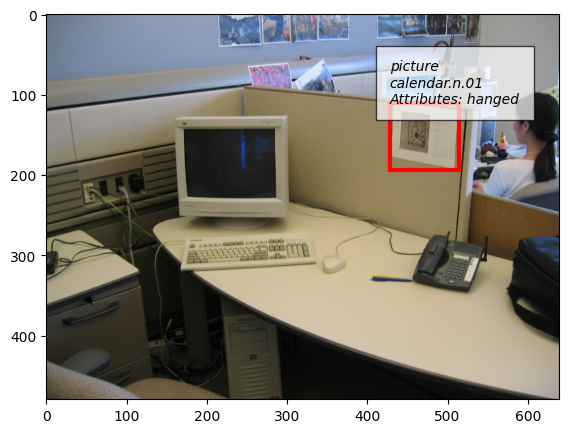

In [5]:
vg.visualize_objects(3, object_ids=[1060294])

In [6]:
print(vg.OBJECTS[1058545])  # an example object without attribute
print(vg.OBJECTS[1058543])  # an example object with a single attribute

for attr in vg.OBJECTS[1058542]['attributes']: # an example object with 2 attributes
    print(attr)

{'object': object id: 1058545, x: 178, y: 0, width: 476, height: 360, name: tree, image id: 1, synset: tree.n.01, 'attributes': [], 'relationships': [id: 3186267: tree next to street, synset: next.r.01]}
{'object': object id: 1058543, x: 0, y: 1, width: 135, height: 535, name: wall, image id: 1, synset: wall.n.01, 'attributes': [id: 31, object_id: 1058543, attribute: grey, synset: grey.s.01, image_id: 1], 'relationships': []}
id: 29, object_id: 1058542, attribute: parked, synset: parked.a.01, image_id: 1
id: 30, object_id: 1058542, attribute: white, synset: white.a.01, image_id: 1


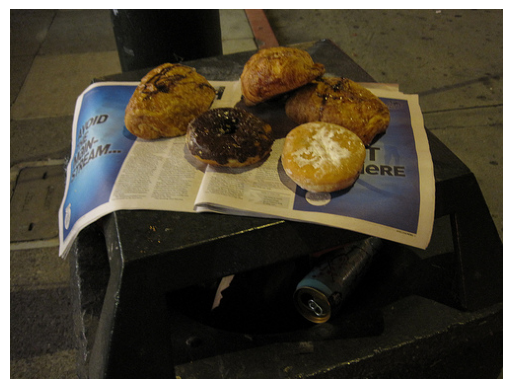

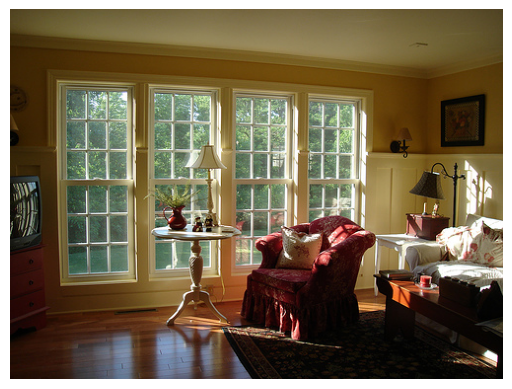

In [7]:
img = vg.sample_images() # sample single image - returns an IMAGE object
vg.display_image(img)

## or directly
vg.display_random_image()

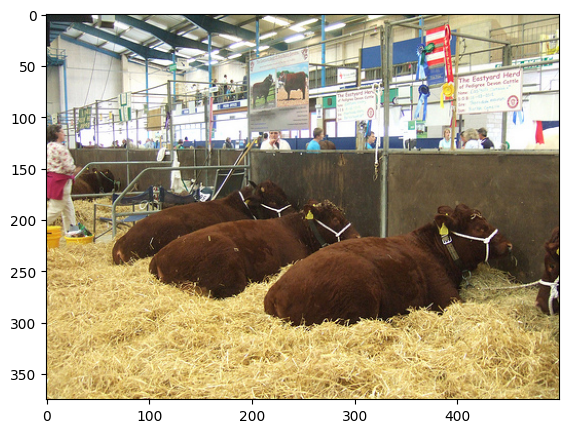

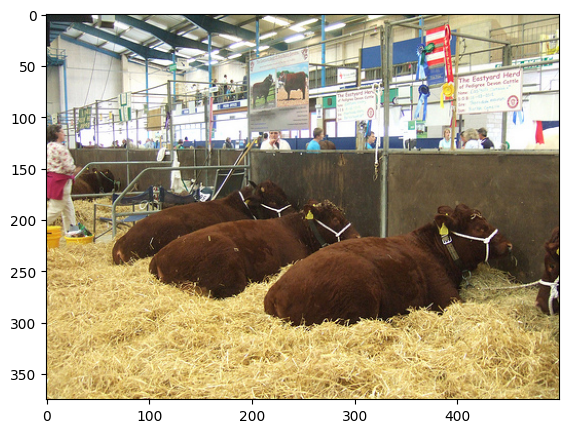

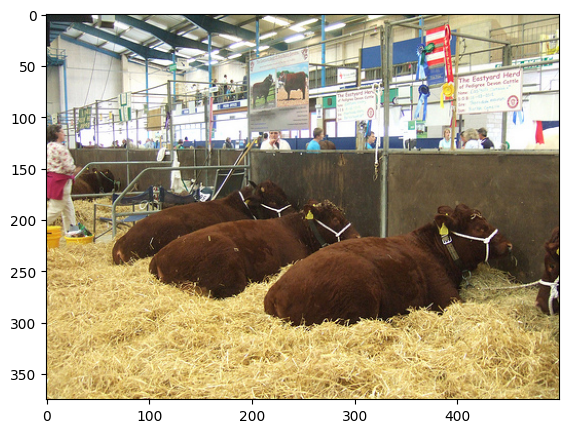

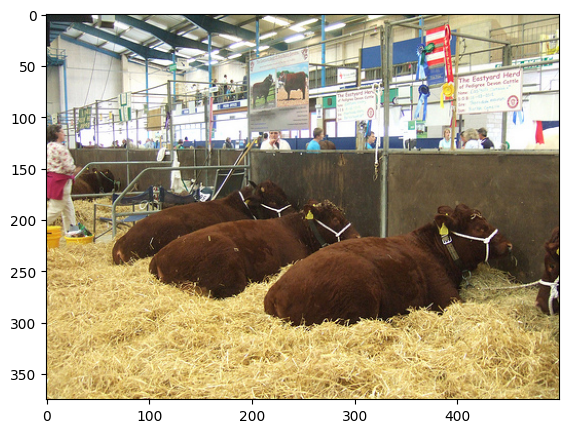

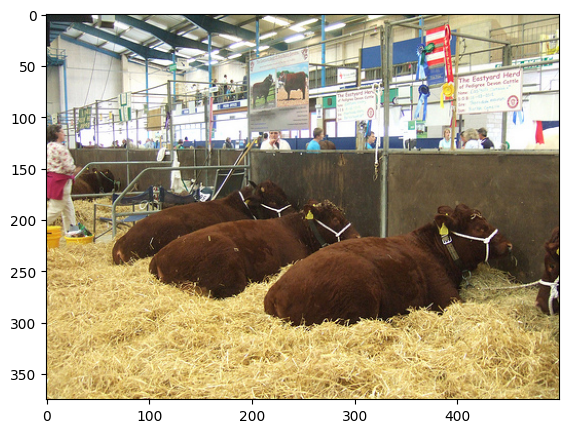

In [8]:
# 2408156: This is an image that includes objects with multiple synsets

# you can visualize the objects in an image 
vg.visualize_objects(2408156, 5)
# visualize without synsets
vg.visualize_objects(2408156, 5, synsets=False)
# visualize without any description
vg.visualize_objects(2408156, 5, desc=False)
# visualize without objects
vg.visualize_objects(2408156, 0) # same as display_image(2408156)
# visualize without attributes
vg.visualize_objects(2408156, 5, attributes=False)

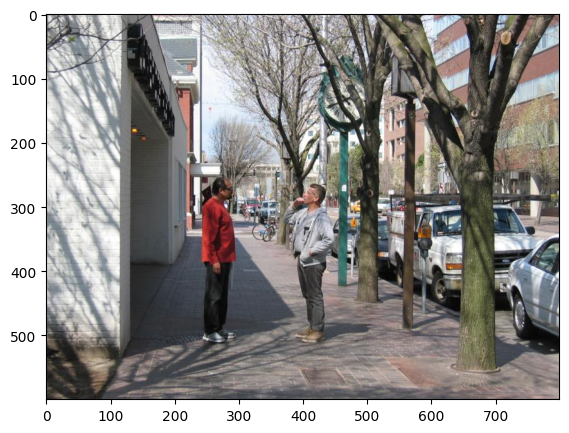

In [9]:
vg.visualize_objects(1, 5)

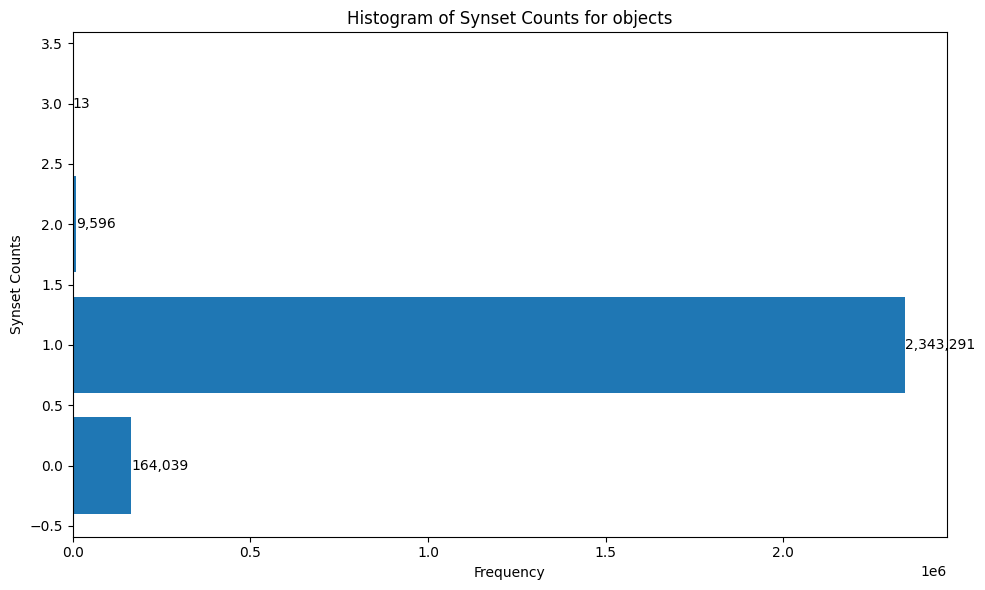

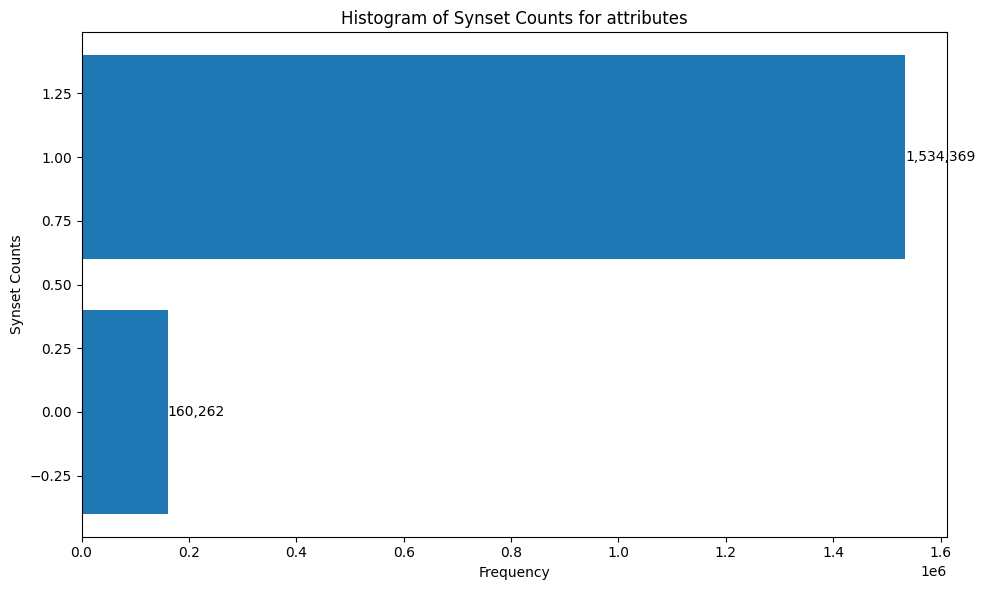

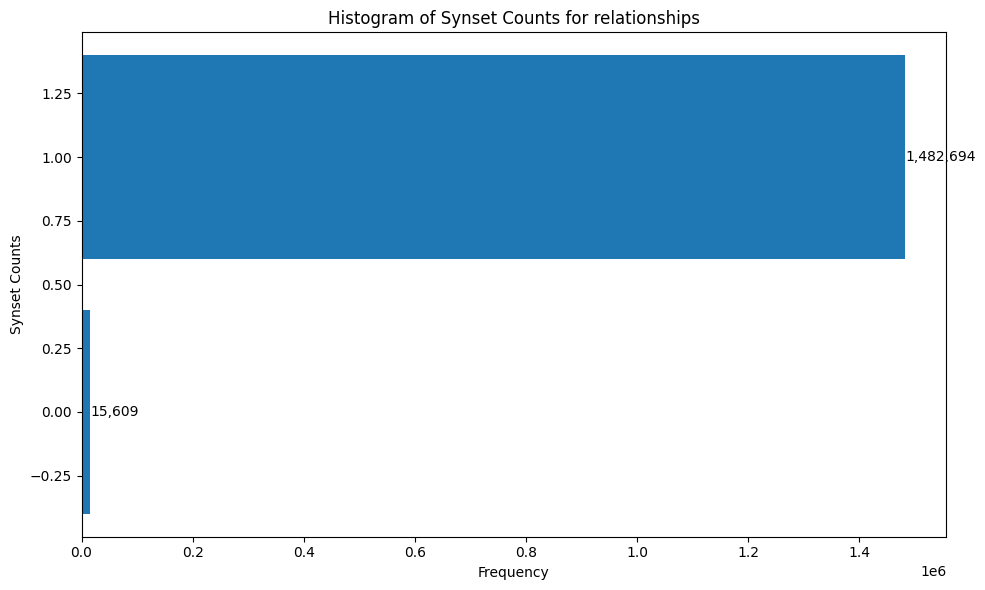

In [10]:
vg.synset_histogram("objects")
vg.synset_histogram("attributes")
vg.synset_histogram("relationships")

In [11]:
# get images with 0 objects
# you can call this function to get images with exactly n objects
# or images with at least n objects (by setting at_least to True)
images_with_no_objects = vg.get_images_with_n_objects(0)
print("Number of images with no objects: ", len(images_with_no_objects))

Number of images with no objects:  1793


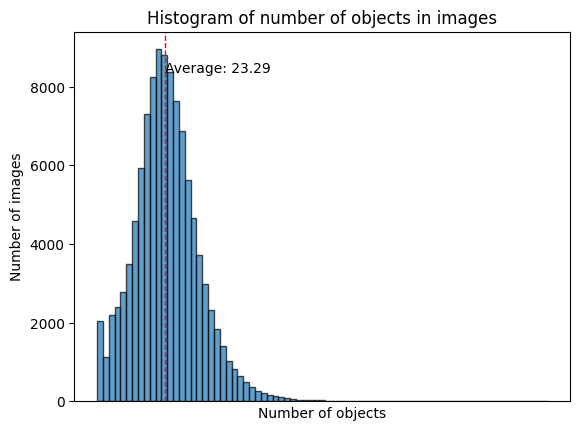

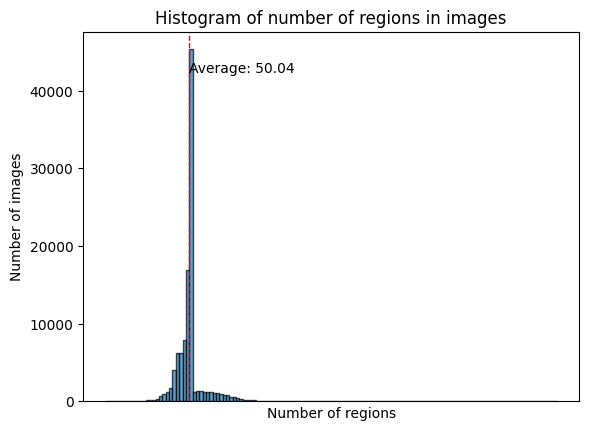

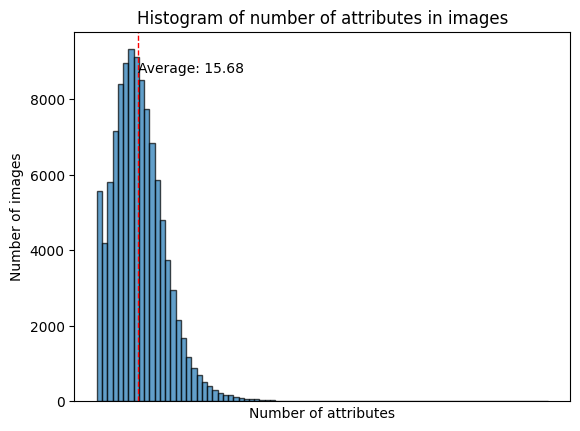

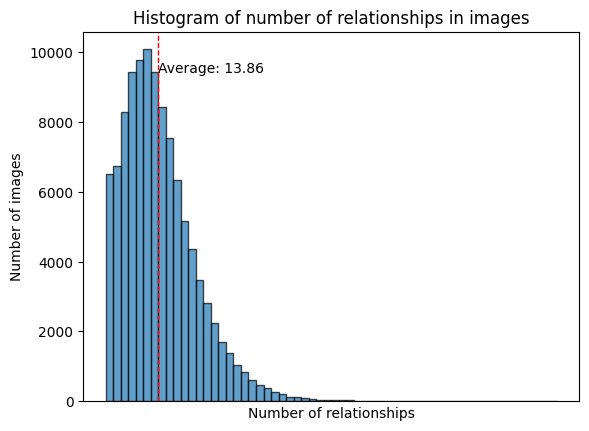

In [12]:
# Example usage
vg.histogram("objects")
vg.histogram("regions")
vg.histogram("attributes")
vg.histogram("relationships")

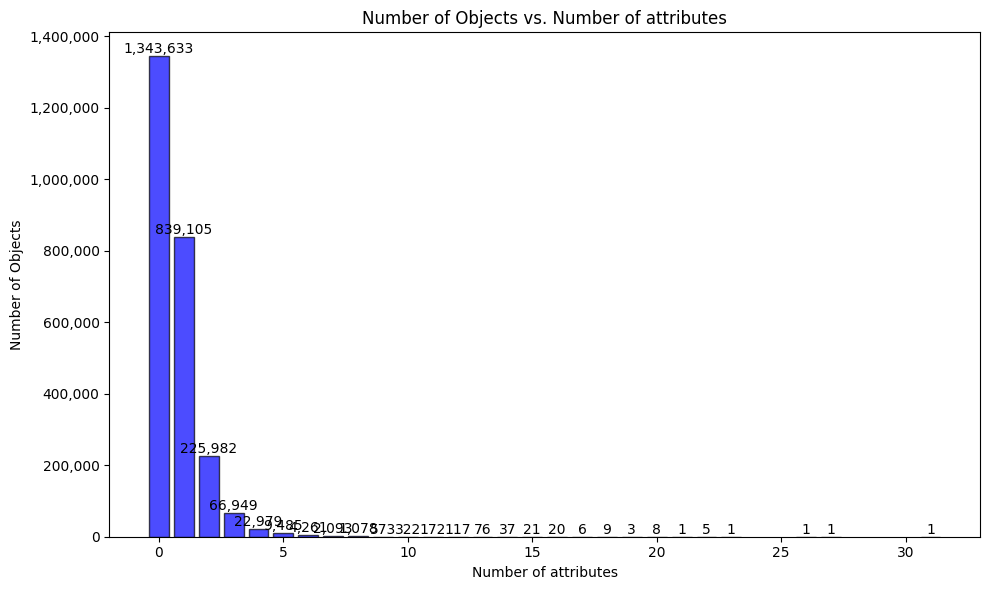

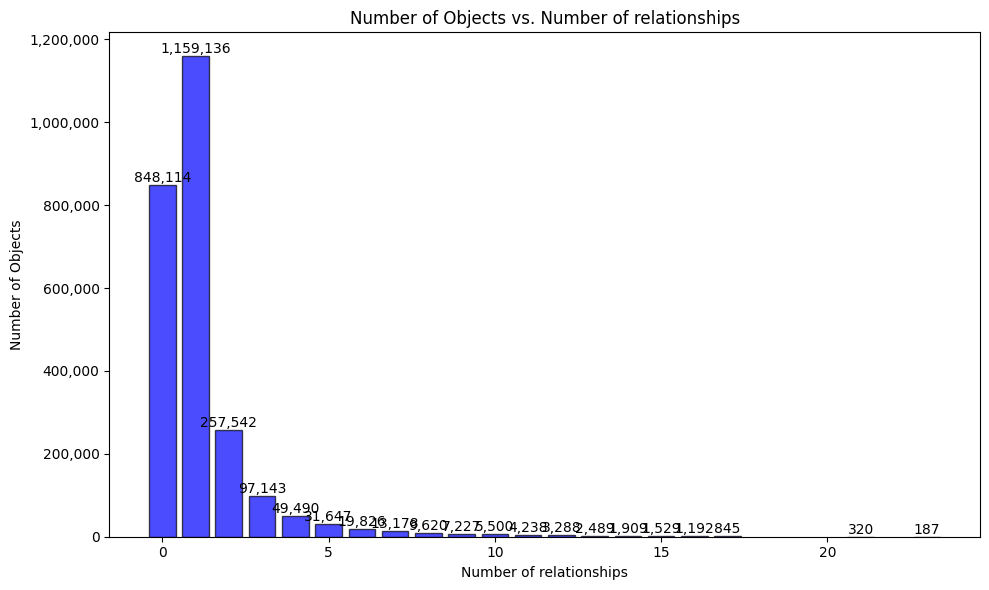

In [13]:
vg.object_histogram("attributes")
vg.object_histogram("relationships")

### Analysis of Merged Objects

In [14]:
merged_object_ids = set()
object_ids = set()

import os, json
import visual_genome.utils as utils
data_dir = utils.get_data_dir()
data_file = os.path.join(data_dir, "objects.json")
images = json.load(open(data_file))

for img in images:
    for obj in img['objects']:
        object_ids.add(obj['object_id'])
        if 'merged_object_ids' in obj:
            merged_object_ids.update(obj['merged_object_ids'])

object_ids_attributes = set()
merged_object_ids_attributes = set()
attribute_objects = set()
for attr_id in vg.ATTRIBUTES.keys():
    attr = vg.ATTRIBUTES[attr_id]
    object_id = attr.object_id
    attribute_objects.add(object_id)
    if object_id in object_ids:
        object_ids_attributes.add(object_id)
    if object_id  in merged_object_ids:
        merged_object_ids_attributes.add(object_id)


union = object_ids.union(merged_object_ids)
diff = attribute_objects.difference(union)

print("Number of merged objects: ", len(merged_object_ids))
print("Number of objects: ", len(object_ids))
print("Number of objects in attributes.json", len(attribute_objects))
print("Number of objects in attributes.json that are in objects.json ", len(object_ids_attributes))
print("Number of objects in attributes.json that are in merged objects: ", len(merged_object_ids_attributes))
print("Number of objects in attributes.json that are not in objects.json or merged objects: ", len(diff))

print("{} + {} + {} = {} ?= {}".format(len(object_ids_attributes), 
                                       len(merged_object_ids_attributes), 
                                       len(diff),  
                                       len(object_ids_attributes) 
                                       + len(merged_object_ids_attributes) 
                                       + len(diff), 
                                       len(attribute_objects)))


Number of merged objects:  546302
Number of objects:  2516939
Number of objects in attributes.json 1670655
Number of objects in attributes.json that are in objects.json  1173306
Number of objects in attributes.json that are in merged objects:  208892
Number of objects in attributes.json that are not in objects.json or merged objects:  288457
1173306 + 208892 + 288457 = 1670655 ?= 1670655


### Number of Attributes and Relationships 

In [15]:
imgs = vg.get_images()
attr_count = 0
rel_count = 0
for img in imgs:
    attr_count += len(vg.get_image_attributes(img))
    rel_count += len(vg.get_image_relationships(img))

print("Number of pairwise relationships in images: ", rel_count)    
print("Number of attributes in images: ", attr_count)

Number of pairwise relationships in images:  1498303
Number of attributes in images:  1694631


### Synset Analysis

In [16]:
# get all objects in the dataset
images = vg.get_images()
attribute_synset_counter = {1: 0, 0: 0}
relationship_synset_counter =  {1: 0, 0: 0}
for image in images:
    objects = vg.get_image_objects(image)
    attributes = vg.get_image_attributes(image)
    relationships = vg.get_image_relationships(image)

    for attr in attributes:
        if(attr.synset is not None):
            attribute_synset_counter[1] += 1
        else:
            attribute_synset_counter[0] += 1
    
    for rel in relationships:
        synset = rel.synset
        if(synset is not None):
            relationship_synset_counter[1] += 1
        else:
            relationship_synset_counter[0] += 1

print("Number of attributes with synsets: ", attribute_synset_counter[1])
print("Number of attributes without synsets: ", attribute_synset_counter[0])

print("Number of relationships with synsets: ", relationship_synset_counter[1])
print("Number of relationships without synsets: ", relationship_synset_counter[0])


Number of attributes with synsets:  1534369
Number of attributes without synsets:  160262
Number of relationships with synsets:  1482694
Number of relationships without synsets:  15609


### Analysis of SAM and SAM 2 Results

In [17]:
import matplotlib.pyplot as plt
import json
from scipy.stats import pearsonr, spearmanr
import numpy as np

In [18]:
# read sam.json from /data 
with open('data/sam.json') as f:
    sam = json.load(f)
# read sam2.json from /data
with open('data/sam2.json') as f:
    sam2 = json.load(f)

# sam: {id: num_of_segmentations}
# convert it to a list of num_of_segmentations

sam_np = np.array(list(sam.values()))
sam2_np = np.array(list(sam2.values()))
print(pearsonr(sam_np, sam2_np))
print("Correlation between SAM and SAM 2:", spearmanr(sam_np, sam2_np).correlation)

PearsonRResult(statistic=np.float64(0.46703531362205164), pvalue=np.float64(0.0))
Correlation between SAM and SAM 2: 0.4730008353223689


In [19]:
vg_num_objects = {} 
for id in sam:
    id = int(id)
    vg_num_objects[id] = len(vg.get_image_objects(id))

vg_num_objects_np = np.array(list(vg_num_objects.values()))
print("Correlation between SAM and VG:", spearmanr(sam_np, vg_num_objects_np))
print("Correlation between SAM 2 and VG:", spearmanr(sam2_np, vg_num_objects_np))

# get mean square error between sam_np and vg_num_objects_np
print("Mean squared error with SAM:", np.mean((sam_np - vg_num_objects_np) ** 2))
print("Mean squared error with SAM 2:", np.mean((sam2_np - vg_num_objects_np) ** 2))

Correlation between SAM and VG: SignificanceResult(statistic=np.float64(0.2821527262278329), pvalue=np.float64(0.0))
Correlation between SAM 2 and VG: SignificanceResult(statistic=np.float64(0.14203523625771813), pvalue=np.float64(0.0))
Mean squared error with SAM: 14997.849958825653
Mean squared error with SAM 2: 434.3521933436346


In [20]:
# get mean square error between sam_np and vg_num_objects_np
print(np.mean((sam_np - vg_num_objects_np) ** 2))
print(np.mean((sam2_np - vg_num_objects_np) ** 2))

14997.849958825653
434.3521933436346


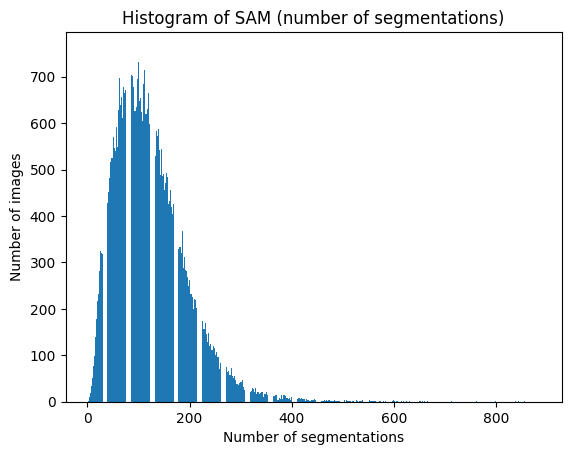

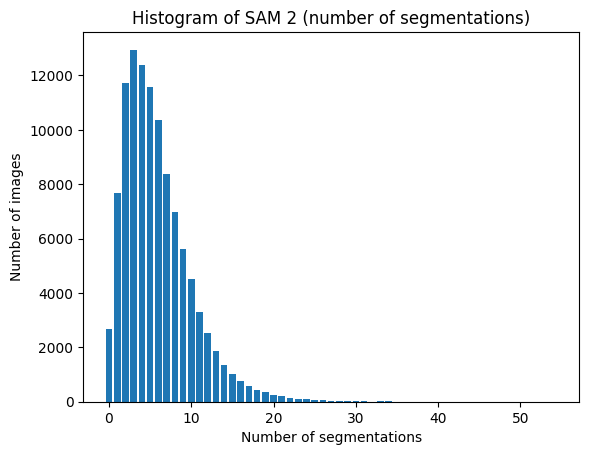

In [21]:
def histogram(data):
    hist = {}
    for d in data:
        if d in hist:
            hist[d] += 1
        else:
            hist[d] = 1
    return hist

hist1 = histogram(sam_np)
hist2 = histogram(sam2_np)

def plot(hist, method):
    # plot
    plt.bar(hist.keys(), hist.values())
    plt.title(f"Histogram of {method} (number of segmentations)")
    plt.xlabel("Number of segmentations")
    plt.ylabel("Number of images")
    plt.show()

plot(hist1, "SAM")
plot(hist2, "SAM 2")


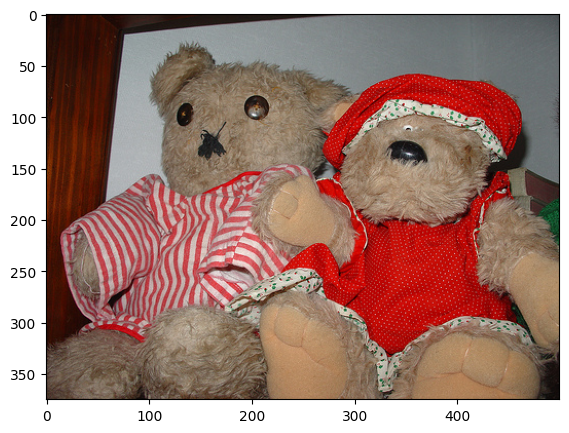

16

In [22]:
vg.visualize_objects(2344501, 0)
len(vg.IMAGES[2344501]["objects"])